In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import matplotlib.patches as mpatches
from scipy import stats

##### These plots use the dataframe created by Dandan. 

In [3]:
nb_path = pathlib.Path().resolve()
data_path = nb_path.parent / 'data'

In [17]:
plots_path = data_path / 'processed' / 'QC2' / 'plots' / 'summary_plots'

In [4]:
file = data_path / 'dandan' / 'Output_dataframe' / 'NYBG_Carbon_fluxes.csv'

In [8]:
# read in output dataframe

df = pd.read_csv(file, parse_dates = ['Date'])

df['Type'] = df['Label'].str[-3:-1]
df['Number'] = df['Label'].str[-1]

In [9]:
# read in file containing chamber temperature

file = data_path / 'processed' / 'QC2'
df2 = pd.read_csv(os.path.join(file, 'NYBG_CO2_Flux_and_Temps.csv'), parse_dates = ['Date'])
df2['Day'] = df2['Date'].dt.date.astype('datetime64[ns]')

df2.drop(22,axis=0, inplace = True)

In [10]:
# merge the two dataframes

merge = pd.merge(df, df2, how = 'outer', left_on = ['Date','Label'], right_on = ['Day', 'Collar'])   # merge files

In [11]:
def linear_fit(x,y):
    """Get slope, intercept and r2 for given x, y variables"""
    
    boo_x = ~np.isnan(x)
    boo_y = ~np.isnan(y)
    boo=np.logical_and(boo_x,boo_y)
    slope, intercept, r, p, std_err = stats.linregress(x[boo],y[boo])
    return slope,intercept, r

def myfunc(x, slope, intercept):
    """Equation of the regression line based on linear_fit"""
    
    return slope * x + intercept

In [19]:
def make_scatter_plots(grouped):
    """Plot respiration vs. soil temperature for each collar type"""
    
    colors = ['#8dd3c7','#ffd92f','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69']
    types = ['TP', 'SV', 'ML', 'FE', 'FI', 'HL', 'UL']
    color_dict = dict(zip(types,colors))
    
    for name, group in grouped:
        fig, ax = plt.subplots()
        group.plot('Soil temperature', 'Res', kind='scatter', color=color_dict[name], ax=ax)
        
        slope, intercept, r = linear_fit(group['Soil temperature'], group['Res'])
        x_range = np.arange(group['Soil temperature'].min(), group['Soil temperature'].max())
        model = myfunc(x_range,slope,intercept)
        ax.plot(x_range,model)
        ax.set_title(f'{name}: {np.around(r,3)}')
        ax.set_ylabel('[\u03BCmol CO$_{2}$ m$^{-2}$ s$^{-1}]$')
        ax.set_ylim(0,40)
        plt.tight_layout()
        plt.show()
        fig.savefig(os.path.join(plots_path, f'soil_temp_plot_{name}.png'))
        plt.close()

In [20]:
def make_scatter_plots_means(grouped):
    """Plot daily mean respiration vs. daily mean soil temperature for each collar type"""
    
    colors = ['#8dd3c7','#ffd92f','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69']
    types = ['TP', 'SV', 'ML', 'FE', 'FI', 'HL', 'UL']
    color_dict = dict(zip(types,colors))
    
    for name, group in means_by_type:
        fig, ax = plt.subplots()
        group.plot('Mean_Temp', 'Mean_Respiration', kind='scatter', color=color_dict[name], ax=ax)
        
        slope, intercept, r = linear_fit(group['Mean_Temp'], group['Mean_Respiration'])
        x_range = np.arange(group['Mean_Temp'].min(),group['Mean_Temp'].max())
        model = myfunc(x_range,slope,intercept)
        ax.plot(x_range,model)
        ax.set_title(f'{name}: {np.around(r,3)}')
        ax.set_ylabel('Mean CO2 Flux [\u03BCmol CO$_{2}$ m$^{-2}$ s$^{-1}]$')
        ax.set_xlabel('Mean Soil Temperature')
        ax.set_ylim(0,40)
        plt.tight_layout()
        plt.show()
        fig.savefig(os.path.join(plots_path, f'means_plot_{name}.png'))
        plt.close()

In [21]:
def make_scatter_plots_chamber_temps(grouped):
    """Plot respiration vs. chamber temperature for each collar type"""
    
    colors = ['#8dd3c7','#ffd92f','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69']
    types = ['TP', 'SV', 'ML', 'FE', 'FI', 'HL', 'UL']
    color_dict = dict(zip(types,colors))
    
    for name, group in grouped:
        fig, ax = plt.subplots()
        group.plot('Chamber_Temp', 'Res', kind='scatter', color=color_dict[name], ax=ax)
        
        slope, intercept, r = linear_fit(group['Chamber_Temp'], group['Res'])
        x_range = np.arange(group['Chamber_Temp'].min(),group['Chamber_Temp'].max())
        model = myfunc(x_range,slope,intercept)
        ax.plot(x_range,model)
        ax.set_title(f'{name}: {np.around(r,3)}')
        ax.set_ylabel('[\u03BCmol CO$_{2}$ m$^{-2}$ s$^{-1}]$')
        ax.set_xlabel('Chamber Temperature')
        ax.set_ylim(0,40)
        plt.tight_layout()
        plt.show()
        fig.savefig(os.path.join(plots_path, f'chamber_temp_plot_{name}.png'))
        plt.close()

In [15]:
def make_line_plot(grouped):
    """Plot time series of soil temperature and respirations for each collar"""
    
    for name, group in grouped:
        fig, ax = plt.subplots(figsize=(10,5))
        group.dropna(subset='Soil temperature').plot('Date', 'Soil temperature', ax=ax)
        group.dropna(subset='Res').plot('Date', 'Res', ax=ax, secondary_y=True)
        ax.set_title(name)
       
        plt.show()
        plt.close()

In [16]:
# create group objects

grouped_dates = df.groupby(['Date', 'Type'])
grouped_type = df.groupby('Type')
grouped_type_chamber = merge.groupby('Type_x')

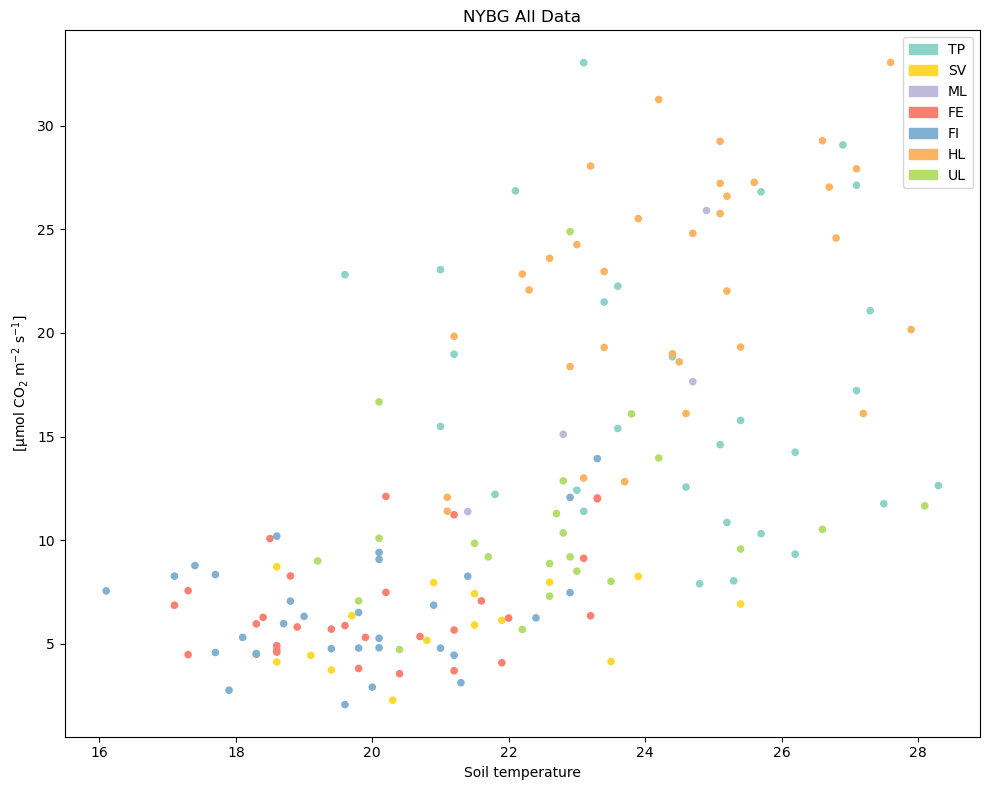

In [18]:
# plot all data on one axis

colors = ['#8dd3c7','#ffd92f','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69']
types = ['TP', 'SV', 'ML', 'FE', 'FI', 'HL', 'UL']
color_dict = dict(zip(types,colors))

fig, ax = plt.subplots(figsize=(10,8))

df.plot('Soil temperature', 'Res', ax=ax, kind='scatter', color=df['Type'].replace(color_dict))

# get legend info
patch_list = []
i = 0
for t in types:
    patch_list.append(mpatches.Patch(label=t, color=colors[i]))
    i += 1

plt.ylabel('[\u03BCmol CO$_{2}$ m$^{-2}$ s$^{-1}]$')
plt.legend(handles=patch_list)
plt.title('NYBG All Data')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(plots_path, 'nybg_all_data.png'))
plt.close()

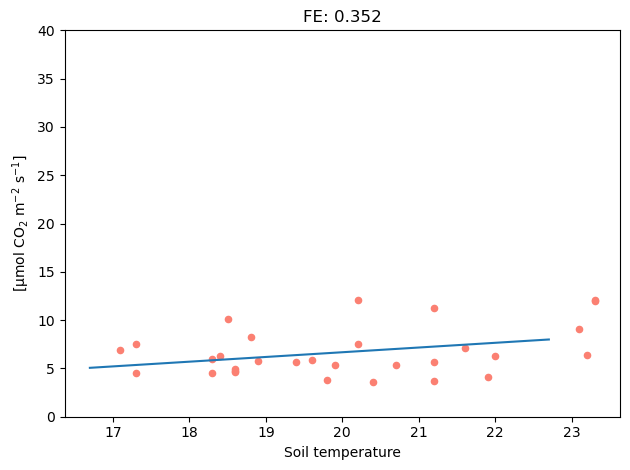

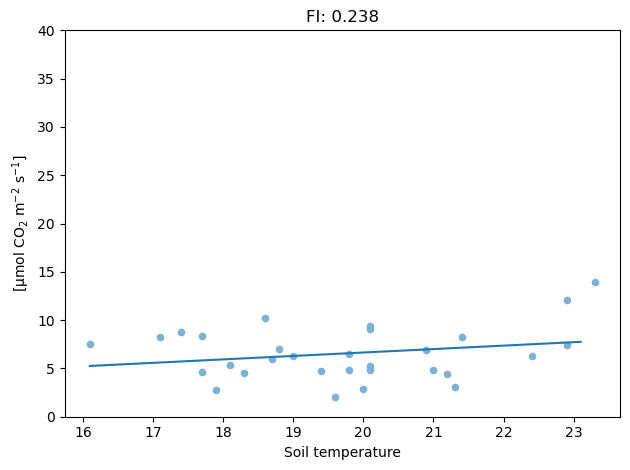

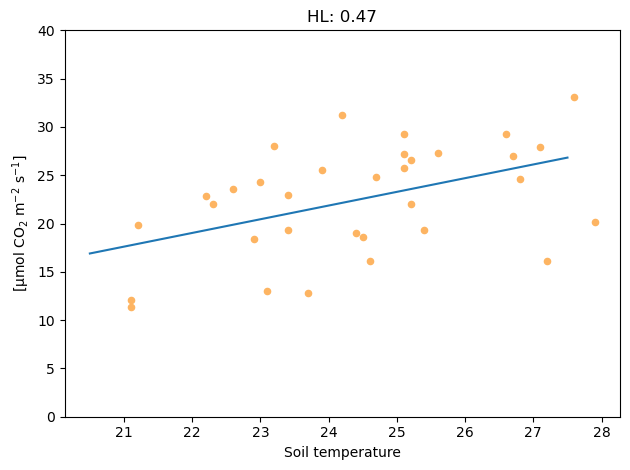

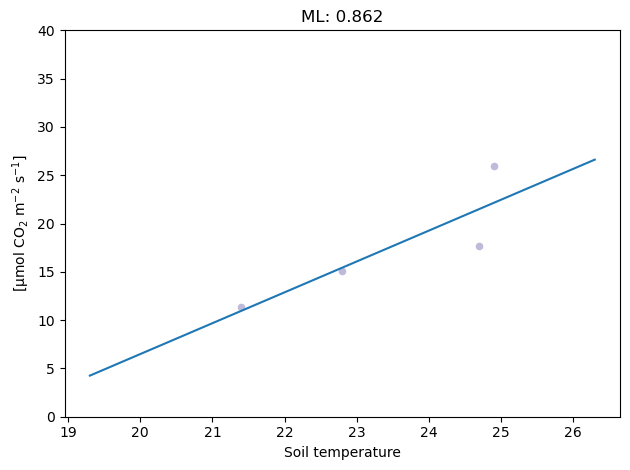

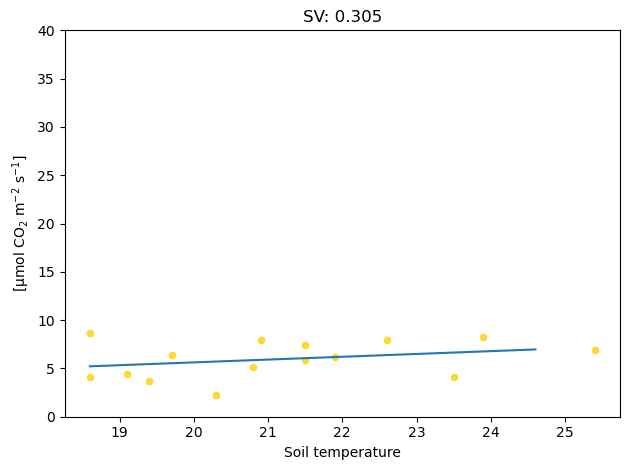

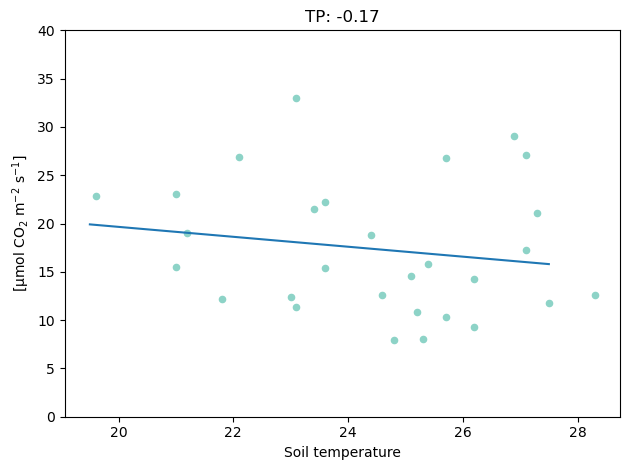

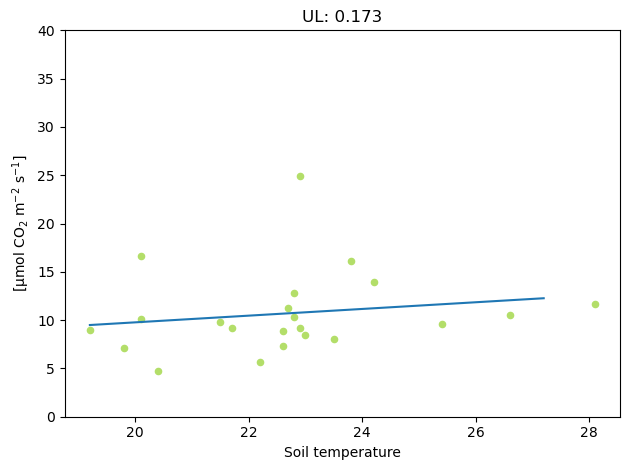

In [22]:
make_scatter_plots(grouped_type)

In [23]:
# get mean respiration and temperature for each type

dates = []
types = []
resp_mean = []
temp_mean = []
se = []

for name, group in grouped_dates:
    if name[1] in ['TP', 'SV', 'UL', 'ML']:
        dates.append(name[0])
        types.append(name[1])
        resp_mean.append(group['Res'].mean())
        temp_mean.append(group['Soil temperature'].mean())
        se.append(stats.sem(group['Res']))
       
        
    elif name[1] in ['FE', 'FI', 'HL']:
        group = grouped_dates.get_group(name)
        mean_34 = group['Res'].loc[(group['Number']=='3') | (group['Number']=='4')].mean()
        mean_12 = group['Res'].loc[(group['Number']=='1') | (group['Number']=='2')].mean()
        mean_array = np.array([mean_34,mean_12])
        
        temp_34 = group['Soil temperature'].loc[(group['Number']=='3') | (group['Number']=='4')].mean()
        temp_12 = group['Soil temperature'].loc[(group['Number']=='1') | (group['Number']=='2')].mean()
        temp_array = np.array([temp_34,temp_12])
                              
        dates.append(name[0])
        types.append(name[1])
        resp_mean.append(mean_array.mean())
        temp_mean.append(temp_array.mean())
       

In [24]:
means_df = pd.DataFrame({'Date':dates, 'Type':types, 'Mean_Respiration':resp_mean, 'Mean_Temp':temp_mean})

In [25]:
means_by_type = means_df.groupby('Type')

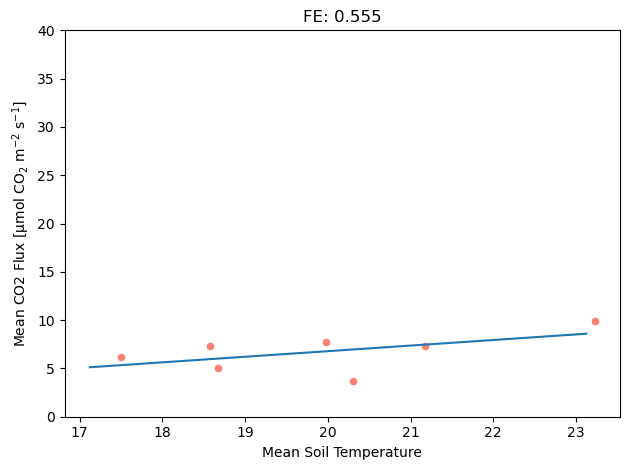

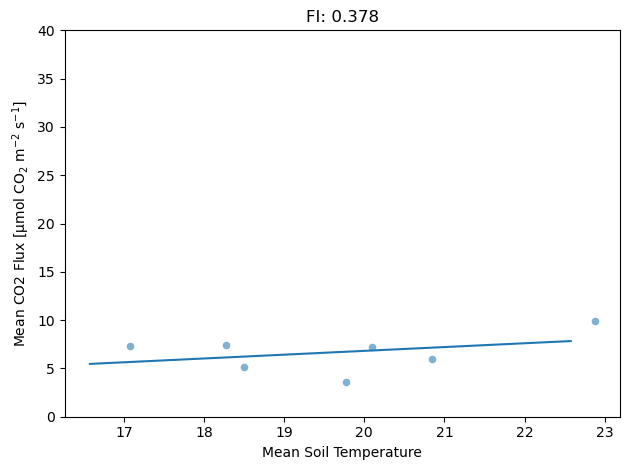

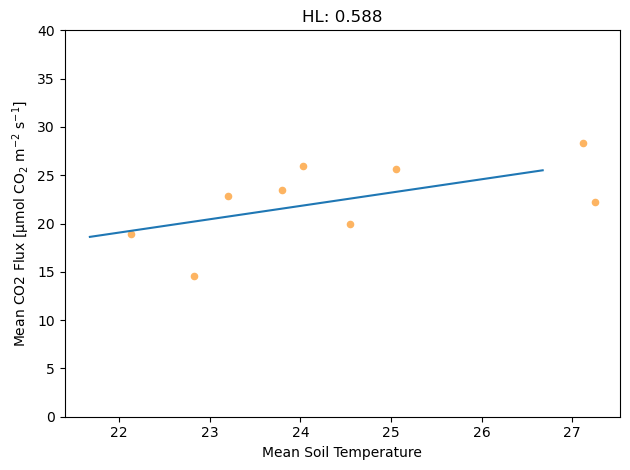

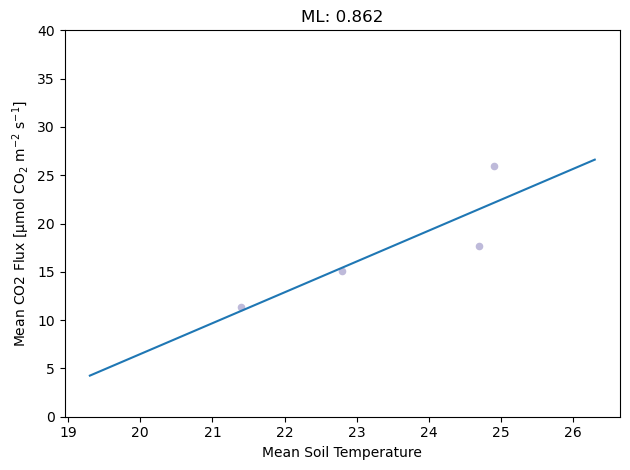

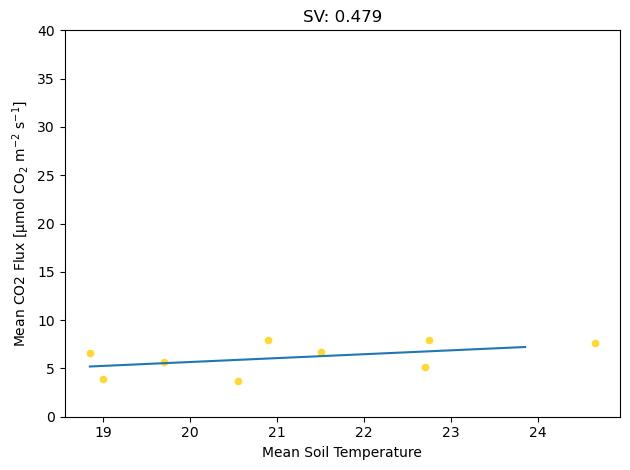

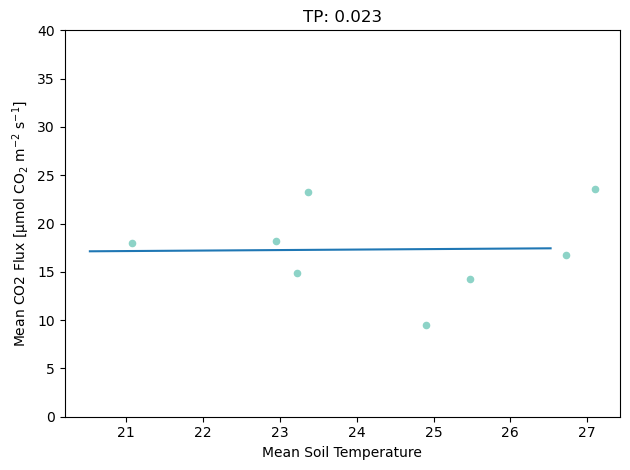

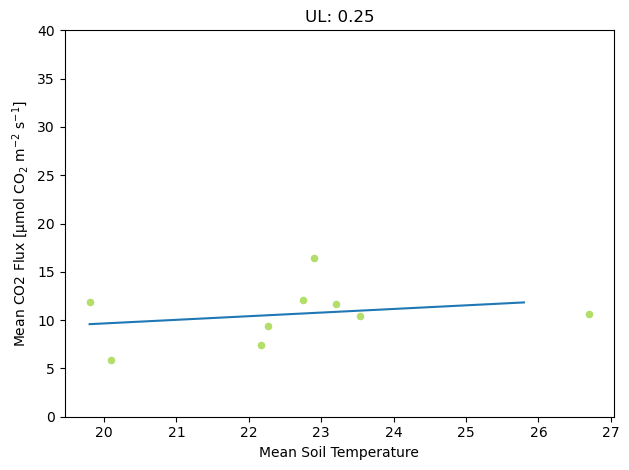

In [26]:
make_scatter_plots_means(means_by_type)

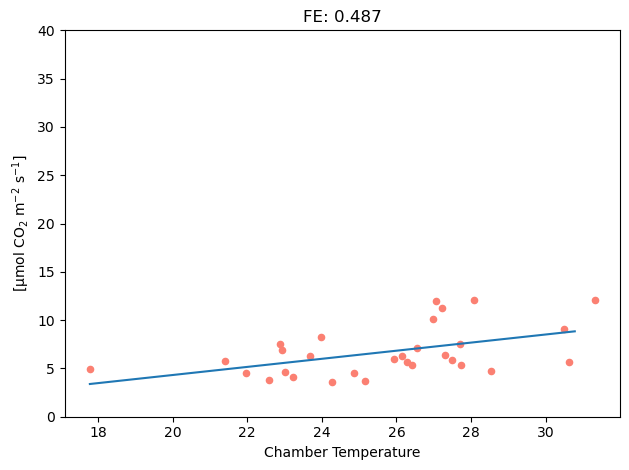

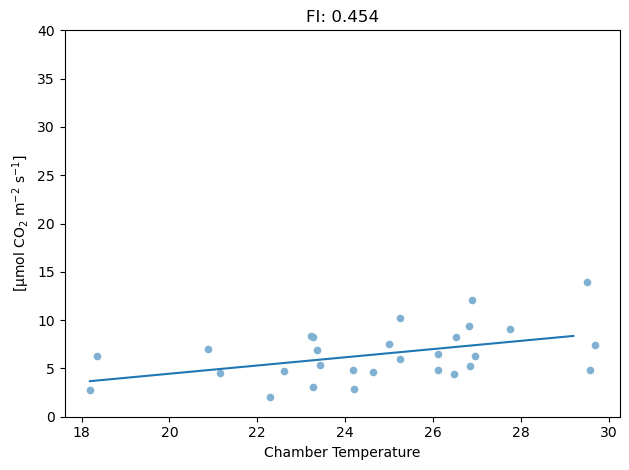

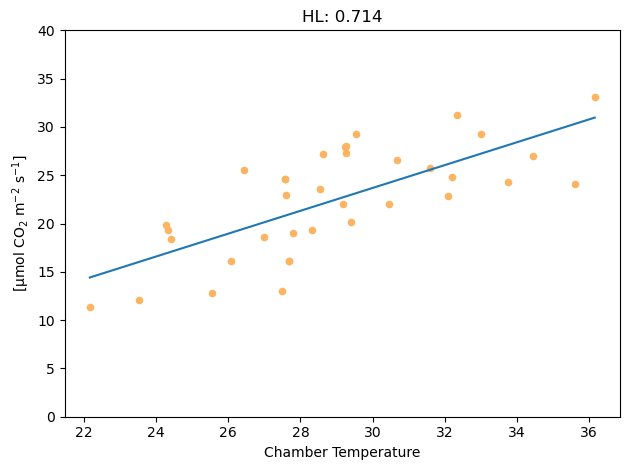

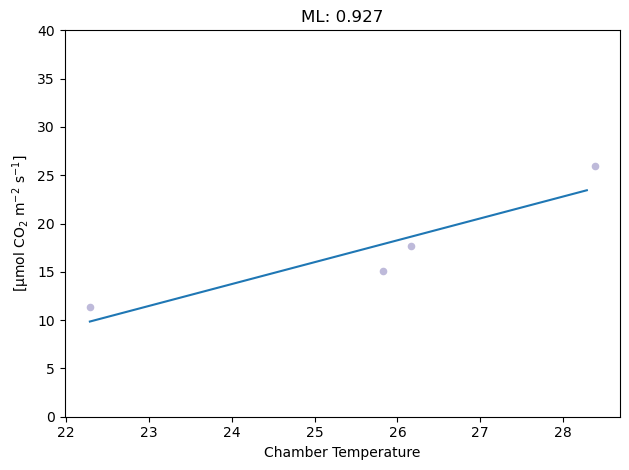

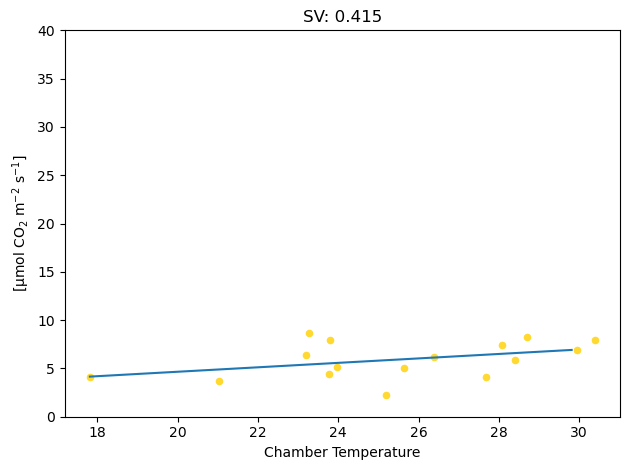

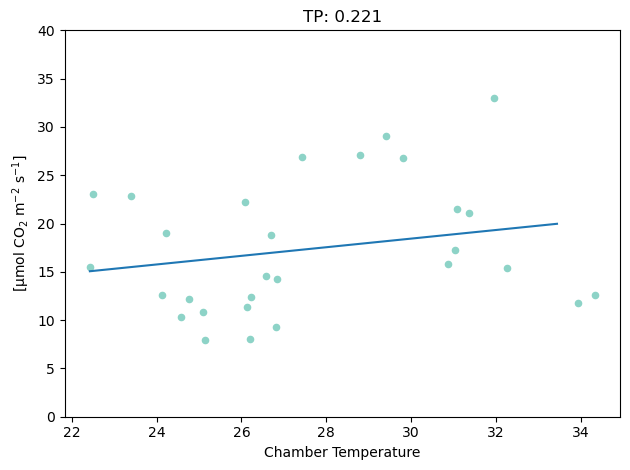

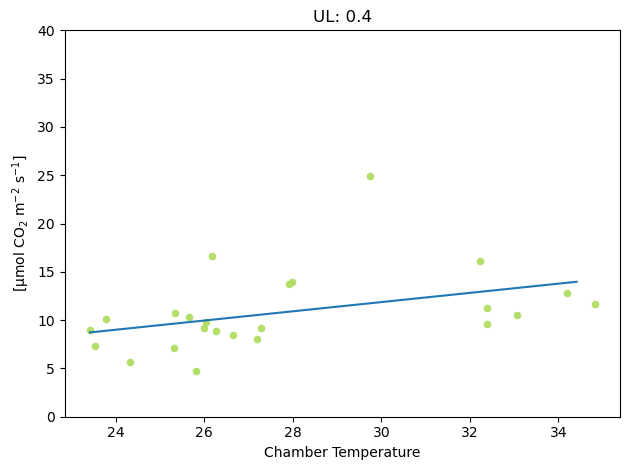

In [27]:
make_scatter_plots_chamber_temps(grouped_type_chamber)